# Load Libraries and set global variables

In [2]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import numpy as np
import utils

from datasets import load_dataset
from gluonts.dataset.pandas import PandasDataset
from huggingface_hub import hf_hub_download

from uni2ts.model.moirai import MoiraiForecast


TIME_COL = "Date"
TARGET = "visits"
DYNAMIC_COV = ['CPI', 'Inflation_Rate', 'GDP']
SEAS_COV=['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7','month_8', 'month_9', 'month_10', 'month_11', 'month_12']
FORECAST_HORIZON = 8 # months
FREQ = "M"

# Load Data

In [3]:
# load data and exogenous features
df = pd.DataFrame(load_dataset("zaai-ai/time_series_datasets", data_files={'train': 'data.csv'})['train']).drop(columns=['Unnamed: 0'])
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

# one hot encode month
df['month'] = df[TIME_COL].dt.month
df = pd.get_dummies(df, columns=['month'], dtype=int)

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head()

Distinct number of time series: 304


,Date,unique_id,visits,CPI,Inflation_Rate,GDP,static_1,static_2,static_3,static_4,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1998-01-01,AAAHol,2015.444457,67.4,0.009,3.996740e+11,A,A,A,Hol,...,0,0,0,0,0,0,0,0,0,0
1,1998-02-01,AAAHol,514.337600,67.4,0.009,3.996740e+11,A,A,A,Hol,...,0,0,0,0,0,0,0,0,0,0
2,1998-03-01,AAAHol,532.097470,67.4,0.009,3.996740e+11,A,A,A,Hol,...,1,0,0,0,0,0,0,0,0,0
3,1998-04-01,AAAHol,534.059083,67.4,0.009,3.996740e+11,A,A,A,Hol,...,0,1,0,0,0,0,0,0,0,0
4,1998-05-01,AAAHol,505.222272,67.4,0.009,3.996740e+11,A,A,A,Hol,...,0,0,1,0,0,0,0,0,0,0


# Split data between train and test

In [4]:
# 8 months to test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]

print(f"Months for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Months for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Months for training: 220 from 1998-01-01 to 2016-04-01
Months for testing: 8 from 2016-05-01 to 2016-12-01


# Forecast

### Dataset Preprocessing
 - Scaling is handled internally

In [5]:
# create GluonTS dataset from pandas
ds = PandasDataset.from_long_dataframe(
    pd.concat([train, test[["unique_id", TIME_COL]+DYNAMIC_COV+SEAS_COV]]).set_index(TIME_COL), # concatenaation with test dynamic covaraiates
    item_id="unique_id",
    feat_dynamic_real=DYNAMIC_COV+SEAS_COV,
    target=TARGET,
    freq=FREQ
)

## MOIRAI

In [15]:
# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id="Salesforce/moirai-R-large", filename="model.ckpt"
    ),
    prediction_length=FORECAST_HORIZON,
    context_length=24,
    patch_size='auto',
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(ds)

# convert forecast into pandas
forecast_df = utils.moirai_forecast_to_pandas(forecasts, test, FORECAST_HORIZON, TIME_COL)

## Plot Actuals and Forecast

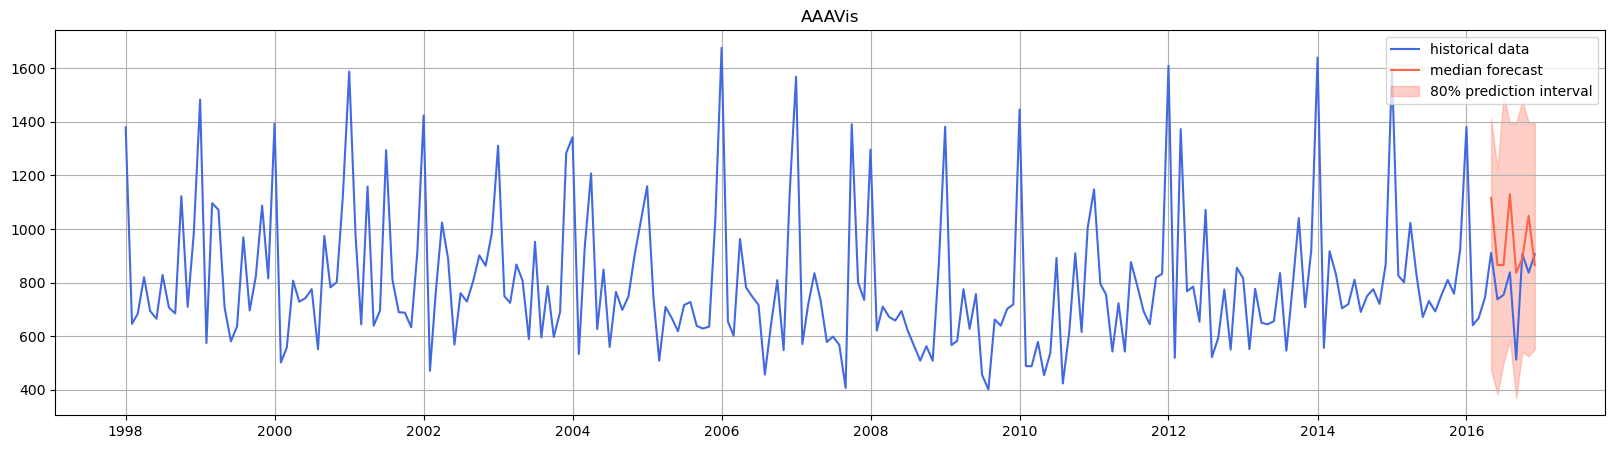

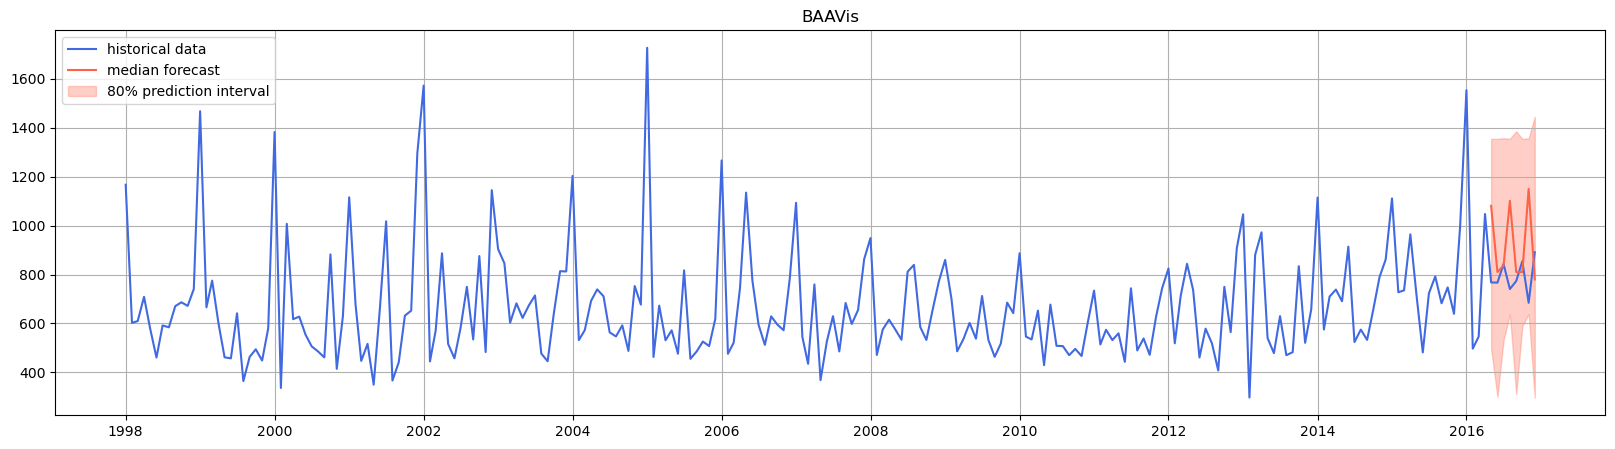

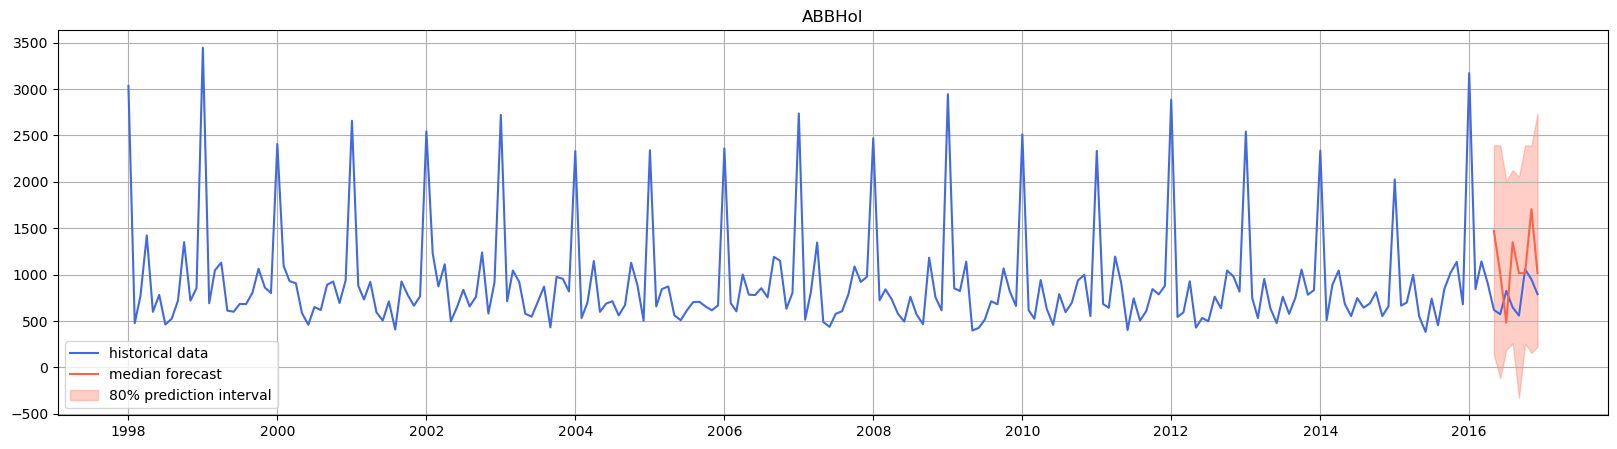

In [12]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

for ts in series[:3]:
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_df[forecast_df["unique_id"] == ts], ts)

# Model Evaluation

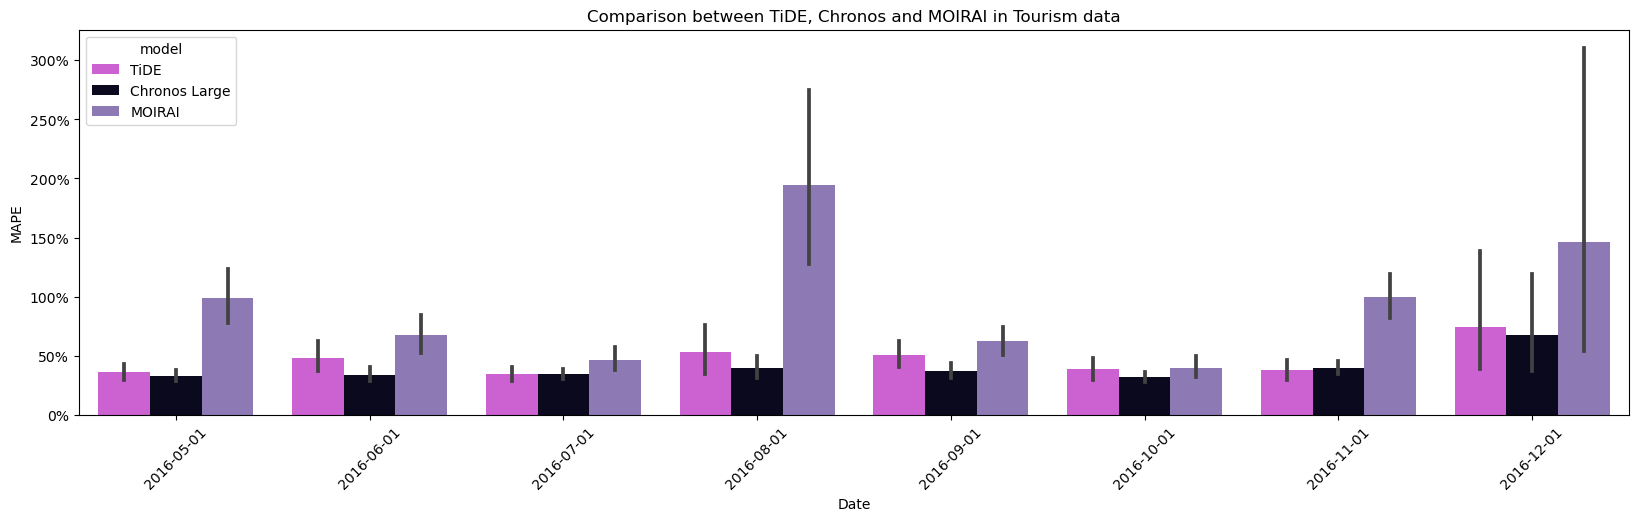

In [17]:
# load the forecast from our current model in production
tide_model_df = pd.read_csv('data/tide.csv', parse_dates=[TIME_COL])
chronos_large_df = pd.read_csv('data/chronos_large.csv', parse_dates=[TIME_COL])
moirai_df = pd.read_csv('data/moirai.csv', parse_dates=[TIME_COL])

# merge data frames with forecast and actuals
model_eval_df = pd.merge(test[['unique_id', TIME_COL, TARGET]], tide_model_df[['unique_id', TIME_COL, 'TiDE']], on=['unique_id', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['unique_id', TIME_COL, 'Chronos Large']], on=['unique_id', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, moirai_df[['unique_id', TIME_COL, 'MOIRAI']], on=['unique_id', TIME_COL], how='inner')

# check performance for top 100 series
top_100 = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(100)

utils.plot_model_comparison(model_eval_df[model_eval_df['unique_id'].isin(top_100['unique_id'])])